Cài đặt các thư viện cần thiết, đọc dư liệu từ file Project_1_coauthor_edges.csv

In [1]:
import networkx as nx
import pandas as pd
import community as community_louvain  
import igraph as ig
from cdlib import algorithms
import community.community_louvain as community_louvain
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv(r"C:\Users\thean\Documents\Social_Network\Social_Network_Projects\Dataset\Project_1_coauthor_edges.csv")
# Chuyển Weight về int
df["Weight"] = df["Weight"].astype(str).str.extract(r"(\d+)").astype(int)
df.head()

Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'infomap', 'wurlitzer', 'bayanpy', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'infomap', 'wurlitzer'}


,Author1,Author2,Weight
0,Joseph Sambrook,Elisabeth Fritsch,1
1,Joseph Sambrook,Tom Maniatis,1
2,Elisabeth Fritsch,Tom Maniatis,1
3,Keith E. Muller,Jacob Cohen,1
4,Jacob Cohen,Peter A. Lachenbruch,1


In [2]:
# Tạo graph từ edge list
# NetworkX Graph
G = nx.from_pandas_edgelist(df, "Author1", "Author2", edge_attr="Weight")

# iGraph Graph
ig_graph = ig.Graph.TupleList(df.itertuples(index=False),
                              directed=False, weights=True)

print("Số node:", G.number_of_nodes())
print("Số cạnh:", G.number_of_edges())


Số node: 9212
Số cạnh: 136198


# Phân cụm cộng đồng tác giả

In [3]:
# Loại bỏ multi-edges
# Dùng Graph() thay vì Graph.MultiGraph()
ig_graph = ig.Graph.TupleList(
    ((u, v, d["Weight"]) for u, v, d in G.edges(data=True)), 
    directed=False, 
    weights=True
)
# --- Louvain (networkx + community_louvain) ---
louvain_partition = community_louvain.best_partition(G)
labels_louvain = list(louvain_partition.values())

# --- Leiden ---
leiden_partition = ig_graph.community_leiden(objective_function="modularity")
labels_leiden = leiden_partition.membership

# --- Fast Greedy ---
fg_partition = ig_graph.community_fastgreedy().as_clustering()
labels_fg = fg_partition.membership

print("Số cộng đồng (Louvain):", len(set(labels_louvain)))
print("Số cộng đồng (Leiden):", len(set(labels_leiden)))
print("Số cộng đồng (Fast Greedy):", len(set(labels_fg)))

# ==============================
# 4. Đánh giá phân cụm
# ==============================

# ---- Modularity ----
mod_louvain = community_louvain.modularity(louvain_partition, G)
mod_leiden  = leiden_partition.modularity
mod_fg      = fg_partition.modularity

print("\n Modularity:")
print("  Louvain:", mod_louvain)
print("  Leiden :", mod_leiden)
print("  Fast Greedy:", mod_fg)

# ---- Normalized Mutual Information (NMI) ----
nmi_louvain_leiden = normalized_mutual_info_score(labels_louvain, labels_leiden)
nmi_louvain_fg     = normalized_mutual_info_score(labels_louvain, labels_fg)
nmi_leiden_fg      = normalized_mutual_info_score(labels_leiden, labels_fg)

print("\n NMI (so sánh giữa các thuật toán):")
print("  Louvain vs Leiden:", nmi_louvain_leiden)
print("  Louvain vs FastGreedy:", nmi_louvain_fg)
print("  Leiden vs FastGreedy:", nmi_leiden_fg)

# ---- Adjusted Rand Index (ARI) ----
ari_louvain_leiden = adjusted_rand_score(labels_louvain, labels_leiden)
ari_louvain_fg     = adjusted_rand_score(labels_louvain, labels_fg)
ari_leiden_fg      = adjusted_rand_score(labels_leiden, labels_fg)

print("\n Adjusted Rand Index (ARI):")
print("  Louvain vs Leiden:", ari_louvain_leiden)
print("  Louvain vs FastGreedy:", ari_louvain_fg)
print("  Leiden vs FastGreedy:", ari_leiden_fg)

Số cộng đồng (Louvain): 1166
Số cộng đồng (Leiden): 1167
Số cộng đồng (Fast Greedy): 1164

 Modularity:
  Louvain: 0.9416753085878978
  Leiden : 0.9418190438204084
  Fast Greedy: 0.9343458692026828

 NMI (so sánh giữa các thuật toán):
  Louvain vs Leiden: 0.800231353465404
  Louvain vs FastGreedy: 0.7971265121538437
  Leiden vs FastGreedy: 0.9909416119694311

 Adjusted Rand Index (ARI):
  Louvain vs Leiden: 0.2263793068111935
  Louvain vs FastGreedy: 0.21500477072102914
  Leiden vs FastGreedy: 0.9119042986463575


Ba thuật toán cho số lượng cộng đồng gần như tương đương.

**Modularity**:

* Leiden: 0.9418, cao nhất
* Louvain: 0.9415, rất sát Leiden
* Fast Greedy: 0.9343, thấp hơn một chút

Leiden cho kết quả tốt nhất về chất lượng phân cụm

**NMI (Normalized Mutual Information)**:

* Louvain và Leiden: 0.80, mức độ tương đồng khá cao
* Louvain và Fast Greedy: 0.79, tương tự
* Leiden và Fast Greedy: 0.99, gần như giống nhau

**ARI (Adjusted Rand Index)**:

* Louvain và Leiden: 0.226, mức tương đồng thấp
* Louvain và Fast Greedy: 0.215, cũng thấp
* Leiden và Fast Greedy: 0.91, mức tương đồng rất cao

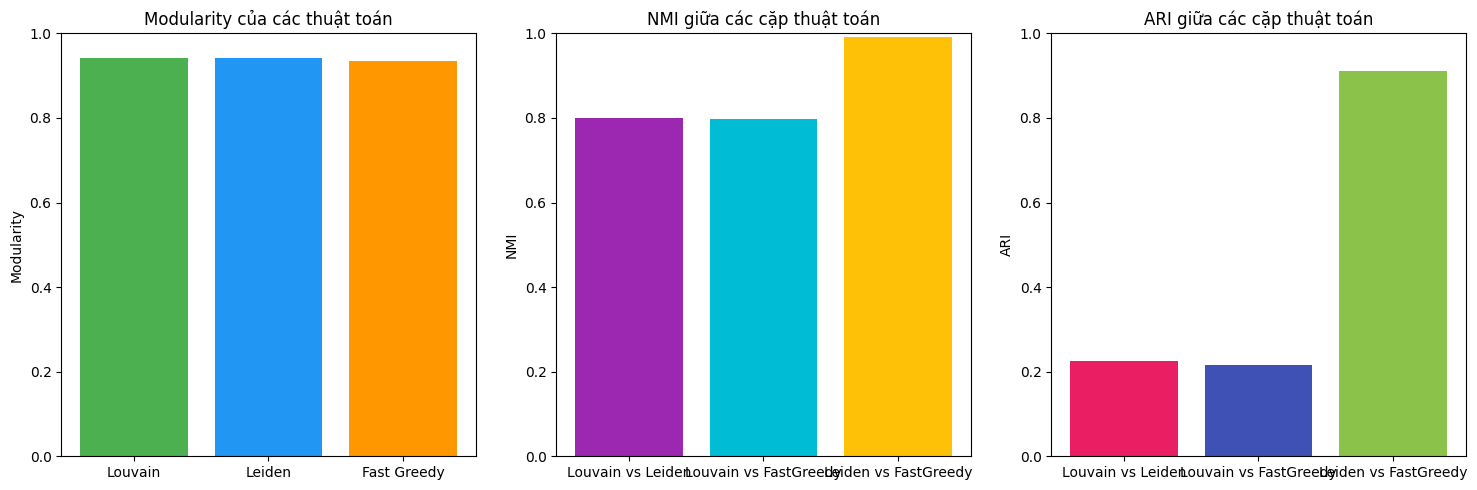

In [4]:
# ==============================
# Trực quan hóa kết quả đánh giá 
# ==============================

# Modularity
mod_scores = {
    "Louvain": mod_louvain,
    "Leiden": mod_leiden,
    "Fast Greedy": mod_fg
}

# NMI giữa các cặp
nmi_scores = {
    "Louvain vs Leiden": nmi_louvain_leiden,
    "Louvain vs FastGreedy": nmi_louvain_fg,
    "Leiden vs FastGreedy": nmi_leiden_fg
}

# ARI giữa các cặp
ari_scores = {
    "Louvain vs Leiden": ari_louvain_leiden,
    "Louvain vs FastGreedy": ari_louvain_fg,
    "Leiden vs FastGreedy": ari_leiden_fg
}

# ==============================
# Vẽ biểu đồ
# ==============================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# --- Biểu đồ Modularity ---
axes[0].bar(mod_scores.keys(), mod_scores.values(), color=['#4CAF50','#2196F3','#FF9800'])
axes[0].set_title("Modularity của các thuật toán")
axes[0].set_ylabel("Modularity")
axes[0].set_ylim(0, 1)

# --- Biểu đồ NMI ---
axes[1].bar(nmi_scores.keys(), nmi_scores.values(), color=['#9C27B0','#00BCD4','#FFC107'])
axes[1].set_title("NMI giữa các cặp thuật toán")
axes[1].set_ylabel("NMI")
axes[1].set_ylim(0, 1)

# --- Biểu đồ ARI ---
axes[2].bar(ari_scores.keys(), ari_scores.values(), color=['#E91E63','#3F51B5','#8BC34A'])
axes[2].set_title("ARI giữa các cặp thuật toán")
axes[2].set_ylabel("ARI")
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()


## Nhận xét trực quan

### Modularity

* Cả ba thuật toán Louvain, Leiden và Fast Greedy đều đạt modularity rất cao (xấp xỉ 0.93–0.94).
* Leiden nhỉnh hơn một chút, Louvain gần bằng, Fast Greedy thấp hơn nhưng không đáng kể.
* Điều này cho thấy cấu trúc cộng đồng trong mạng lưới tác giả rất rõ ràng, cả ba phương pháp đều phát hiện tốt.

### NMI (Normalized Mutual Information)

* NMI giữa Louvain và Leiden, cũng như giữa Louvain và Fast Greedy, đều ở mức khoảng 0.8 → khá cao.
* NMI giữa Leiden và Fast Greedy đạt gần 1 → hai thuật toán này gần như cho ra cùng một cách phân cụm.
* Nhìn chung, các thuật toán đồng thuận mạnh với nhau, chứng tỏ cấu trúc mạng cộng tác ổn định.

### ARI (Adjusted Rand Index)

* ARI giữa Louvain và Leiden (~0.22) và giữa Louvain và Fast Greedy (~0.21) khá thấp, cho thấy Louvain tạo ra khác biệt đáng kể so với hai thuật toán kia.
* Ngược lại, ARI giữa Leiden và Fast Greedy đạt ~0.91, cho thấy hai phương pháp này phân chia cộng đồng gần như giống nhau.

### Kết luận

* Leiden và Fast Greedy cho kết quả tương đồng rất cao cả về NMI và ARI, đồng thời modularity cũng tốt, → có thể coi đây là hai phương pháp đáng tin cậy nhất cho dữ liệu này.
* Louvain tuy modularity vẫn cao, nhưng cách phân cụm khác biệt hơn so với hai thuật toán còn lại.


### Phân tích cộng đồng nghiên cứu


Số nodes: 9212
Số edges: 136198
Top 10 tác giả theo Degree Centrality:
                                       Degree  Betweenness  Closeness  \
Michelle Giglio                      0.026599     0.006484   0.078461   
Ricardo Silva                        0.025947     0.001910   0.072613   
Andrés Mauricio Caraballo‐Rodríguez  0.025947     0.001910   0.072613   
Pascale Gaudet                       0.025079     0.000920   0.073922   
Curtis Huttenhower                   0.023342     0.007732   0.081771   
Chris Mungall                        0.022039     0.000811   0.073193   
Susan Holmes                         0.021605     0.011139   0.074269   
Eric J. Alm                          0.021387     0.005802   0.080477   
Robert S. Fulton                     0.021279     0.004030   0.083453   
Alexey V. Melnik                     0.021279     0.001451   0.070210   

                                     Eigenvector  
Michelle Giglio                         0.097647  
Ricardo Silva          

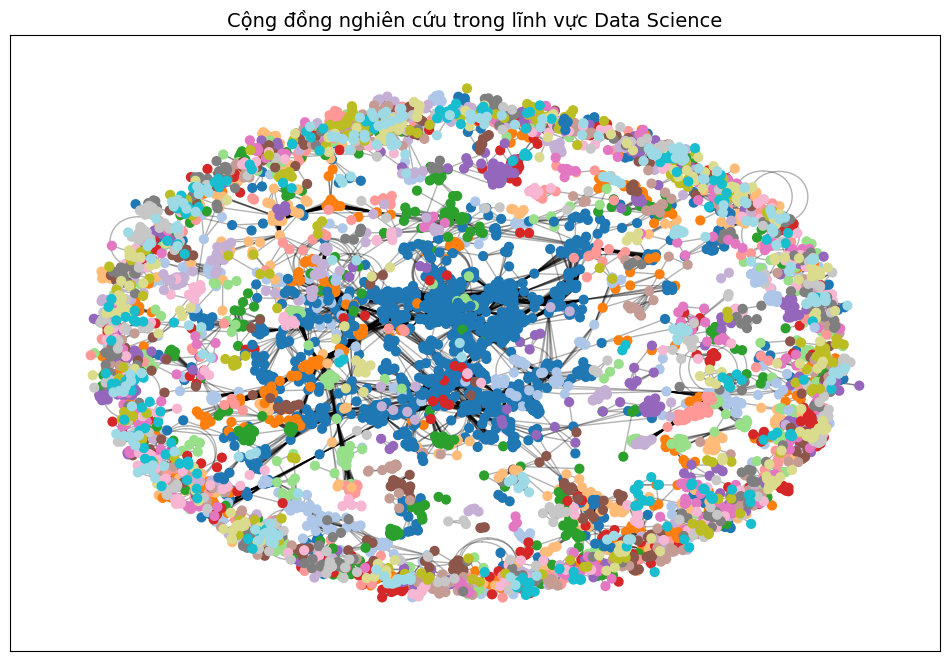

In [5]:
print(f"Số nodes: {G.number_of_nodes()}")
print(f"Số edges: {G.number_of_edges()}")

# ===== 3. Centrality =====
deg_c = nx.degree_centrality(G)
bet_c = nx.betweenness_centrality(G)
close_c = nx.closeness_centrality(G)
eig_c = nx.eigenvector_centrality(G)

centrality_df = pd.DataFrame({
    "Degree": deg_c,
    "Betweenness": bet_c,
    "Closeness": close_c,
    "Eigenvector": eig_c
}).sort_values("Degree", ascending=False)

print("Top 10 tác giả theo Degree Centrality:")
print(centrality_df.head(10))

# ===== 4. Community Detection (Louvain) =====
partition = community_louvain.best_partition(G)
nx.set_node_attributes(G, partition, 'community')

# Xuất cộng đồng
community_df = pd.DataFrame(list(partition.items()), columns=["Author", "Community"])
print("Số cộng đồng tìm được:", community_df['Community'].nunique())

# ===== 5. Visualization =====
plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, seed=42)
cmap = plt.cm.get_cmap("tab20", max(partition.values()) + 1)

nx.draw_networkx_nodes(G, pos, node_size=40, 
                       node_color=[partition[n] for n in G.nodes()],
                       cmap=cmap)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Cộng đồng nghiên cứu trong lĩnh vực Data Science", fontsize=14)
plt.show()

### Nhận xét


-   Michelle Giglio (0.0266) → là tác giả có nhiều cộng tác nhất.

-   Những tác giả như Ricardo Silva, Pascale Gaudet, Curtis Huttenhower cũng có độ kết nối cao.

-   Degree cao → tác giả nằm ở trung tâm mạng, hợp tác với nhiều người.

### Betweenness Centrality

Cho biết tác giả nào là cầu nối giữa các nhóm khác nhau.

Ví dụ: Susan Holmes có betweenness 0.0111 → đóng vai trò kết nối các nhóm nghiên cứu.

### Closeness Centrality

Ai có thể tiếp cận nhanh nhất tất cả các tác giả khác trong mạng.

Curtis Huttenhower (0.0817) → nằm ở vị trí thuận lợi để lan truyền thông tin.

### Eigenvector Centrality

Ai có ảnh hưởng vì kết nối với những tác giả quan trọng khác.

Chris Mungall (0.0999) → mặc dù degree không cao nhất nhưng ảnh hưởng lớn vì liên kết với các tác giả trung tâm.

### Phân tích cộng đồng trong mạng hợp tác tác giả
1. Quy mô mạng

- Số nodes (tác giả): 9212 → tập hợp rất lớn, có nhiều tác giả tham gia vào lĩnh vực nghiên cứu.

- Số edges (cộng tác): 136198 → mạng hợp tác có mật độ cao, cho thấy có sự kết nối rộng rãi giữa các tác giả.

- Số cộng đồng phát hiện được: 1167 → mạng được phân chia thành nhiều cộng đồng nhỏ hơn, phản ánh các nhóm nghiên cứu hay trường phái học thuật khác nhau.

2. Các tác giả trung tâm (Top 10 theo Degree Centrality)

- Michelle Giglio, Pascale Gaudet, Chris Mungall có giá trị Eigenvector Centrality rất cao → không chỉ kết nối rộng rãi mà còn có ảnh hưởng trong những cụm tác giả quan trọng.

- Curtis Huttenhower, Susan Holmes, Eric J. Alm, Robert S. Fulton có Closeness Centrality cao → họ nằm ở vị trí gần trung tâm mạng, dễ dàng tiếp cận và kết nối đến các tác giả khác.

- Susan Holmes có Betweenness Centrality cao nhất trong nhóm top 10 → đóng vai trò “cầu nối” quan trọng giữa các cộng đồng.

3. Cấu trúc cộng đồng

- 1167 cộng đồng được phát hiện cho thấy mạng có cấu trúc phân mảnh tự nhiên, các nhóm nghiên cứu chuyên sâu về những chủ đề cụ thể.

- Một số cộng đồng tập trung quanh những tác giả trung tâm (ví dụ Michelle Giglio, Chris Mungall) → đây có thể là các nhóm nghiên cứu lớn, có nhiều hợp tác và ảnh hưởng.

- Sự tồn tại của nhiều cộng đồng nhỏ phản ánh sự đa ngành, nhiều nhánh nghiên cứu song song trong lĩnh vực.

4. Ý nghĩa

- Việc phân tích cộng đồng giúp nhận diện các nhóm hợp tác mạnh, tác giả chủ chốt, và các cầu nối tri thức trong mạng lưới khoa học.

- Có thể khai thác kết quả này để:

* Xác định các cụm chủ đề nổi bật.

* Tìm ra những tác giả then chốt cần theo dõi để hiểu sự phát triển của lĩnh vực.

* Phát hiện các cộng đồng ít kết nối, từ đó gợi ý hướng tăng cường hợp tác liên ngành.

## Lưu file nodes cho Gephi

In [6]:
# ====== NODES FILE ======
nodes = pd.DataFrame({"Id": list(G.nodes())})

# Thêm cộng đồng theo Louvain
nodes["Louvain"] = [louvain_partition[n] for n in nodes["Id"]]

# Leiden
labels_leiden = {}
for i, comm in enumerate(leiden_partition):
    for v in comm:
        labels_leiden[ig_graph.vs[v]["name"]] = i
nodes["Leiden"] = nodes["Id"].map(labels_leiden)

# Fast Greedy
labels_fg = {}
for i, comm in enumerate(fg_partition):
    for v in comm:
        labels_fg[ig_graph.vs[v]["name"]] = i
nodes["FastGreedy"] = nodes["Id"].map(labels_fg)

# Lưu file nodes
nodes.to_csv("Project1A_coauthor_nodes_gephi.csv", index=False, encoding="utf-8")


In [ ]:
# Đọc nodes hiện tại (Id + Louvain/Leiden/FastGreedy)
nodes = pd.read_csv("Project1A_coauthor_nodes_gephi.csv")

# Đã có centrality_df từ trước (Degree, Betweenness, Closeness, Eigenvector)
# centrality_df.index = Id tác giả
# centrality_df = pd.DataFrame({...}) 

# Map các giá trị centrality vào nodes
nodes["Degree"] = nodes["Id"].map(centrality_df["Degree"])
nodes["Betweenness"] = nodes["Id"].map(centrality_df["Betweenness"])
nodes["Closeness"] = nodes["Id"].map(centrality_df["Closeness"])
nodes["Eigenvector"] = nodes["Id"].map(centrality_df["Eigenvector"])
# Thêm cột tên tác giả từ thuộc tính 'name'
nodes["Name"] = nodes["Id"].map(nx.get_node_attributes(G, "name"))
# Lưu lại file nodes mới cho Gephi
nodes.to_csv("nodes_gephi_with_centrality.csv", index=False, encoding="utf-8")

print("Hoàn tất! File nodes_gephi_with_centrality.csv đã được tạo.")

Hoàn tất! File nodes_gephi_with_centrality.csv đã được tạo.
